In [1]:
import random
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
from torch.distributions import Categorical

import KnockOff

# copy & paste GMM.py into your local torch.distributions
from torch.distributions.GMM import GMM 


seed = 14
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

N=200 # num of samples
D=2 # num of dimension
M=30 # num of relevant
Tensor = torch.FloatTensor # Tensor = torch.DoubleTensor # for float64


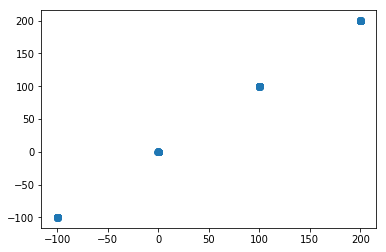

In [2]:
# Four Gaussian
m1 = MultivariateNormal(torch.zeros(D) + 100.,torch.eye(D) * .1)
m2 = MultivariateNormal(torch.zeros(D) - 100.,torch.eye(D) * .1)
m3 = MultivariateNormal(torch.zeros(D),torch.eye(D) * .1)
m4 = MultivariateNormal(torch.zeros(D) + 200,torch.eye(D) * .1)



mix = GMM(Tensor([.25,.25,.25,.25]), [m1,m2,m3,m4], dim=D)
x = mix._sample(N)
# show the scatter for x_tilde pairwise
for i in range(D):
    for j in range(i+1,D):
        plt.scatter(x[:,i],x[:,j])
        plt.show()
        plt.close()

In [3]:
x_dim, h_dim, z_dim= D, [5,5,5,5], D

swap_batch_size = 10

generator = KnockOff.Generator(x_dim, h_dim, z_dim)
discriminator = KnockOff.Discriminator(x_dim, h_dim, x_dim)
f_WGAN = KnockOff.f_MLP(x_dim, h_dim)
# construct MINE
mine = [KnockOff.MINE(h_dim) for i in range(D)] # a net for each dimension
mine_params = [list(m.parameters()) for m in mine][0] # get params for all network



In [4]:

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
optimizer_M = torch.optim.Adam(mine_params, lr=1e-3)
optimizer_f = torch.optim.Adam(f_WGAN.parameters(), lr=1e-3)


ncritic = 10
niter = 10000

In [5]:
G_loss = []
D_loss = []
M_loss = []
f_loss = []

  0%|          | 0/10000 [00:00<?, ?it/s]

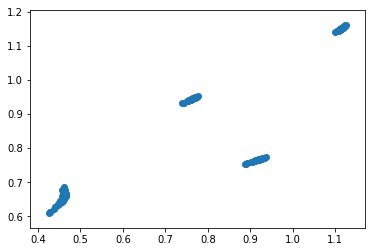

  5%|▍         | 498/10000 [00:09<03:06, 50.87it/s]

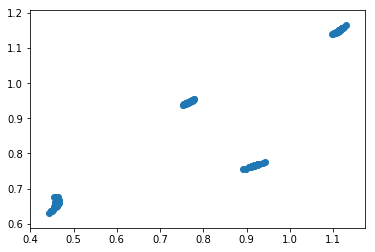

 10%|▉         | 998/10000 [00:19<02:59, 50.12it/s]

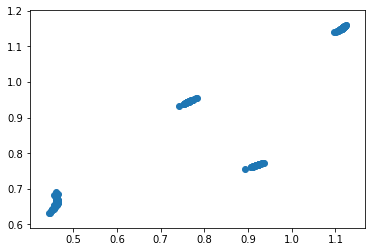

 15%|█▍        | 1497/10000 [00:29<02:49, 50.15it/s]

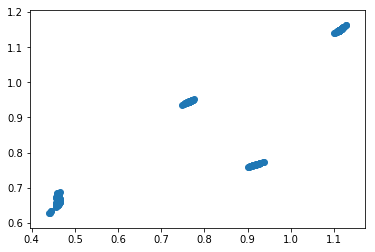

 20%|█▉        | 1999/10000 [00:39<02:39, 50.14it/s]

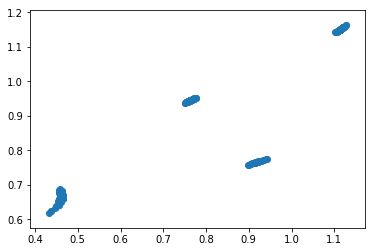

 25%|██▍       | 2496/10000 [00:49<02:30, 49.92it/s]

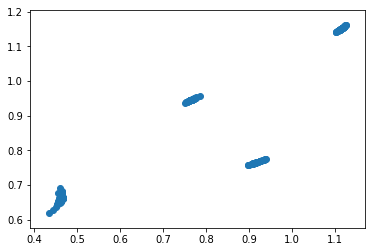

 30%|██▉       | 2999/10000 [01:00<02:20, 49.69it/s]

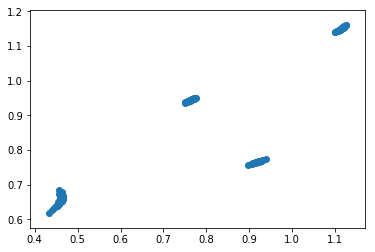

 35%|███▍      | 3497/10000 [01:11<02:12, 49.23it/s]

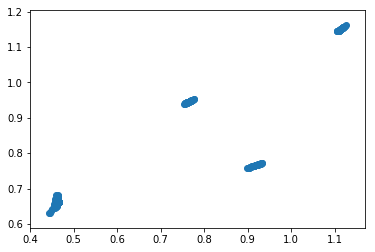

 40%|███▉      | 3998/10000 [01:21<02:02, 49.05it/s]

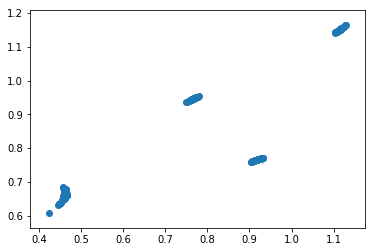

 45%|████▍     | 4496/10000 [01:31<01:52, 48.92it/s]

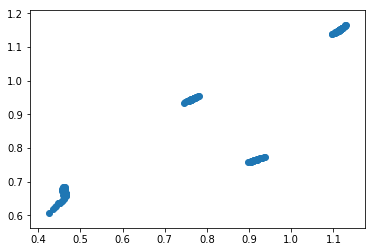

 50%|████▉     | 4997/10000 [01:42<01:42, 48.85it/s]

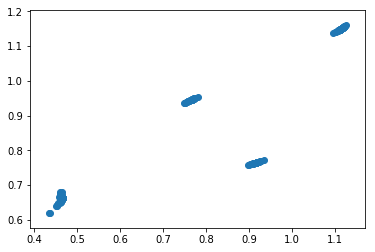

 55%|█████▍    | 5498/10000 [01:52<01:32, 48.81it/s]

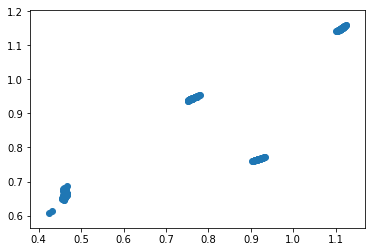

 60%|█████▉    | 5999/10000 [02:03<01:22, 48.70it/s]

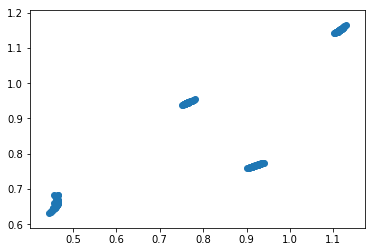

 65%|██████▍   | 6497/10000 [02:13<01:12, 48.55it/s]

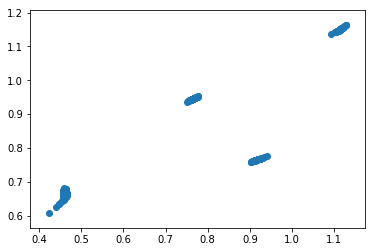

 70%|██████▉   | 6998/10000 [02:24<01:01, 48.54it/s]

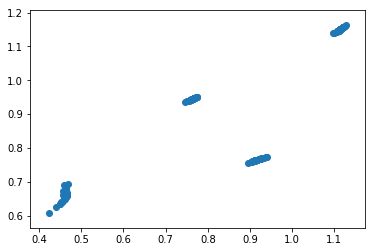

 75%|███████▍  | 7498/10000 [02:34<00:51, 48.47it/s]

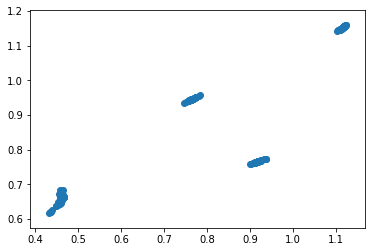

 80%|███████▉  | 7999/10000 [02:45<00:41, 48.41it/s]

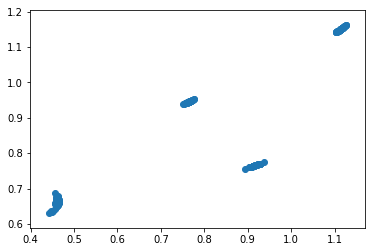

 85%|████████▌ | 8500/10000 [02:55<00:30, 48.45it/s]

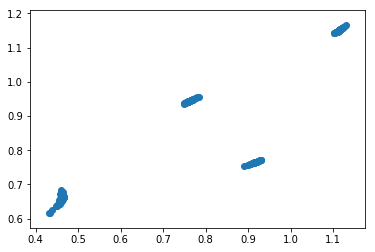

 90%|████████▉ | 8997/10000 [03:05<00:20, 48.49it/s]

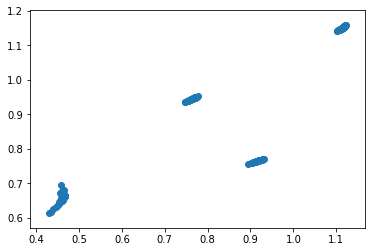

 95%|█████████▍| 9496/10000 [03:15<00:10, 48.54it/s]

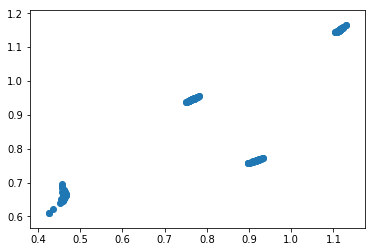

100%|██████████| 10000/10000 [03:25<00:00, 48.62it/s]


In [6]:
for i in tqdm(range(niter)):

    z = Variable(Tensor(np.random.normal(0, 1, (N, z_dim))))
    
    # generate X_tilde
    x_tilde = generator.forward(torch.cat((x,z),1)).detach()
    
    # do swap
    xx,S = KnockOff.random_swap(x,x_tilde,swap_batch_size)
    
    # estimate S
    estimated_S = discriminator.forward(xx)
    
    # max D 
    loss_D = - discriminator.loss(S,estimated_S) # we min its negate
    loss_D.backward(retain_graph=True)
    optimizer_D.step()
    
    # max M 
    perm = torch.randperm(N)# get shuffled X
    x_shuffle=x[perm,:]
    loss_M = 0
    for d in range(D):
        _x = torch.cat(((x_shuffle[:,d].view(N,1),x_tilde[:,d].view(N,1))),-1)
        T1 = torch.mean(mine[d](_x))
        T2 = torch.logsumexp(mine[d](_x),dim=0) - torch.log(Tensor([N]))
        loss_M += (T1 - T2)
    optimizer_M.zero_grad()
    loss_M = - loss_M / D # we min its negate
    
    loss_M.backward(retain_graph=True)
    optimizer_M.step()
    
    # max f; we min its  negate 
    eps = torch.Tensor(N).normal_(0.,1.).view(N,1)
    x_hat = Variable(eps * x + (1-eps) * x_tilde,requires_grad=True)
    grad_x = torch.autograd.grad(f_WGAN.forward(x_hat).split(1),x_hat,create_graph=True)[0]
    grad_x = (grad_x ** 2).sum()
    
    #TODO: hyper para
    loss_f = - (f_WGAN.forward(x) - f_WGAN.forward(x_tilde) - 10 * (grad_x - 1) ** 2).mean() # we min its negate 
    loss_f.backward(retain_graph=True)
    optimizer_f.step()
    
    # min G
    loss_G = loss_D + loss_M + loss_f #TODO: hyper para
    loss_G.backward()
    optimizer_G.step() 
    
    # plot
    G_loss.append(loss_G.detach())
    D_loss.append(-loss_D.detach())
    M_loss.append(-loss_M.detach())
    f_loss.append(-loss_f.detach())
    
    if i % 500 == 0:
        x_tilde_ = generator.forward(torch.cat((x,z),1)).detach()
        plt.scatter(x_tilde_[:,0],x_tilde_[:,-1])
        plt.show()
        plt.close()

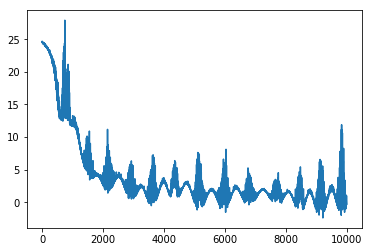

In [7]:
plt.plot(G_loss)
plt.show()

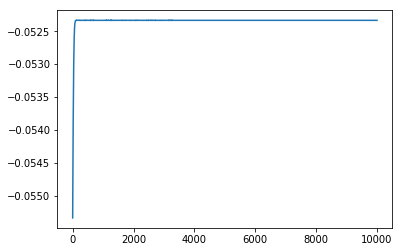

In [8]:
plt.plot(M_loss)
plt.show()

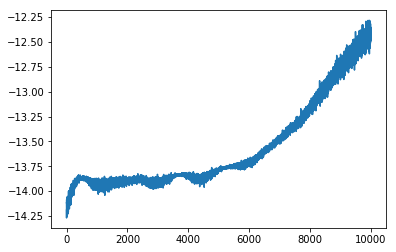

In [9]:
plt.plot(D_loss)
plt.show()

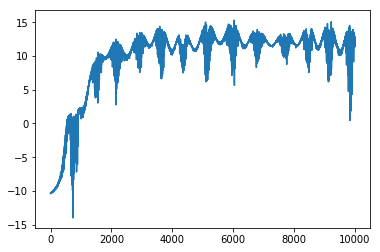

In [10]:
plt.plot(f_loss)
plt.show()